In [26]:
import numpy as np
import pickle
import os
#import download
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import time
from keras.models import load_model
from keras import optimizers
import random
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = "data/CIFAR-10/"
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
num_classes = 10
_num_files_train = 5
_images_per_file = 10000
_num_images_train = _num_files_train * _images_per_file
def _get_file_path(filename=""):
    return os.path.join(data_path, "cifar-10-batches-py/", filename)
def _unpickle(filename):
    file_path = _get_file_path(filename)
    print("Loading data: " + file_path)
    with open(file_path, mode='rb') as file:
        data = pickle.load(file, encoding='bytes')
    return data
def _convert_images(raw):
    raw_float = np.array(raw, dtype=float)/255.0
    images = raw_float.reshape([-1, num_channels, img_size, img_size])
    images = images.transpose([0, 2, 3, 1])

    return images
def _load_data(filename):
    data = _unpickle(filename)
    raw_images = data[b'data']
    cls = np.array(data[b'labels'])
    images = _convert_images(raw_images)

    return images, cls
def load_class_names():

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names
def one_hot_encoded(class_numbers, num_classes=None):
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]
def load_training_data():
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    begin = 0

    for i in range(_num_files_train):
       
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))
        num_images = len(images_batch)
        end = begin + num_images
        images[begin:end, :] = images_batch
        cls[begin:end] = cls_batch
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)
def load_test_data():
    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
images_train, cls_train, labels_train = load_training_data()
test_images, test_cls, labels_test = load_test_data()
test_images1 = test_images.copy()
class_names = load_class_names()
print(class_names)

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


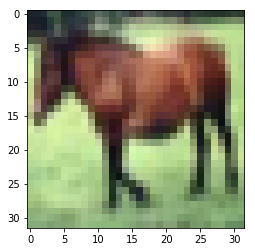

In [4]:
plt.imshow(images_train[7], interpolation = 'nearest') 

{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


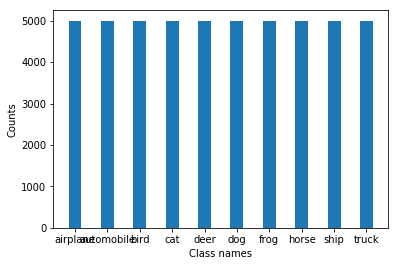

{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


In [5]:
digit_train, counts_train = np.unique(cls_train, return_counts = True)
distribution_train = dict(zip(class_names, counts_train))
print(distribution_train )
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.4)
plt.xlabel('Class names')
plt.ylabel('Counts')
plt.show()
digit_test, counts_test = np.unique(test_cls, return_counts = True)
distribution_test = dict(zip(class_names, counts_test))
print(distribution_test)

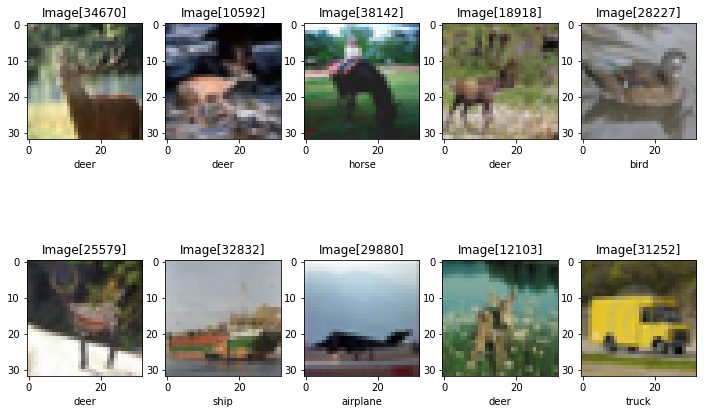

In [6]:
fig_object, ax_object = plt.subplots(2, 5, figsize=(12,8))
ax_object = ax_object.reshape(10,)
for i in range(len(ax_object)):
    ax = ax_object[i]
    rn = random.randint(1,40000)
    ax.imshow(images_train[rn], cmap = plt.cm.binary, interpolation = 'nearest')
    xlabel = "{0}".format(class_names[cls_train[rn]])
    title = "Image[{0}]".format(rn)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
X_train1, X_val1, Y_train, Y_val = train_test_split(images_train, labels_train, test_size=1/12, random_state=42)
X_train1.shape

(45833, 32, 32, 3)

In [8]:
print(X_train1.size)

140798976


In [53]:
X_train_unscaled =  np.resize(X_train1,(45833,3072))
X_val_unscaled = np.resize(X_val1,(4167,3072))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unscaled.astype(np.float32))
X_val_scaled = scaler.fit_transform(X_val_unscaled.astype(np.float32))
X_train =  np.resize(X_train_scaled,(45833,32,32,3))
X_val = np.resize(X_val_scaled,(4167,32,32,3))
#X_train

C:\Users\Lavanya\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 45833 samples, validate on 4167 samples
Epoch 1/50
45833/45833 [==============================] - 498s - loss: 1.3464 - acc: 0.5179 - val_loss: 0.9964 - val_acc: 0.6410
Epoch 2/50
45833/45833 [==============================] - 457s - loss: 0.8774 - acc: 0.6944 - val_loss: 0.8069 - val_acc: 0.7175
Epoch 3/50
45833/45833 [==============================] - 454s - loss: 0.6736 - acc: 0.7651 - val_loss: 0.7629 - val_acc: 0.7339
Epoch 4/50
45833/45833 [==============================] - 455s - loss: 0.5210 - acc: 0.8194 - val_loss: 0.6934 - val_acc: 0.7603
Epoch 5/50
45833/45833 [==============================] - 455s - loss: 0.3860 - acc: 0.8640 - val_loss: 0.7299 - val_acc: 0.7576
Epoch 6/50
45833/45833 [==============================] - 454s - loss: 0.2618 - acc: 0.9100 - val_loss: 0.7426 - val_acc: 0.7778
Epoch 7/50
45833/45833 [==============================] - 508s - loss: 0.1760 - acc: 0.9381 - val_loss: 0.8869 - val_acc: 0.7598
Epoch 8/50
45833/45833 [========================

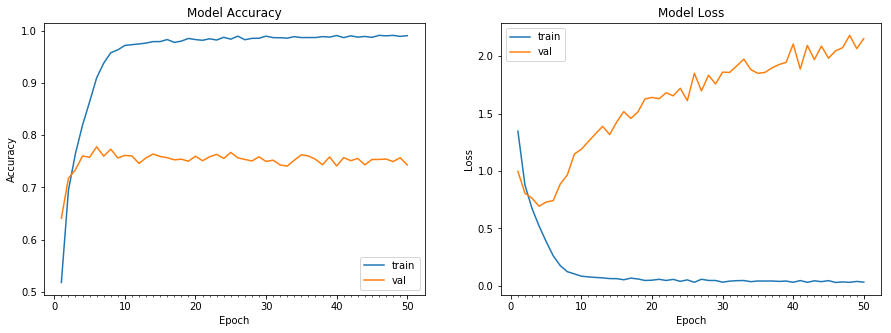

In [58]:
model = Sequential()
model.add(Conv2D(48, (3, 3), activation ='relu',padding='same', input_shape=(32, 32,3)))
model.add(Conv2D(48, (3, 3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation ='relu',padding='same'))
model.add(Conv2D(64, (3, 3), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))

model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
start = time.time()
model_info = model.fit(X_train, Y_train, batch_size=100,nb_epoch=50,validation_data=(X_val,Y_val)) 
end = time.time()

string = "model_info_conv"
model.save(string)  
print("Model took %0.2f seconds to train" %(end - start))
plot_model_history(model_info)
                    

In [59]:
X_test_unscaled = np.resize(test_images1,(10000,3072))
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_unscaled.astype(np.float32))
X_test =  np.resize(X_test_scaled,(10000,32,32,3))

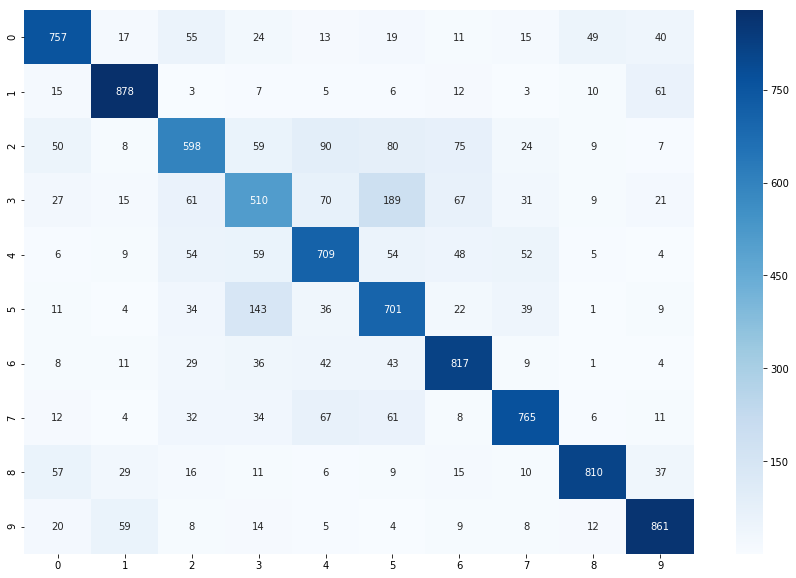

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
y_test_predict = model.predict(X_test)
Confusion_Matrix_test = confusion_matrix(labels_test.argmax(axis=1),y_test_predict.argmax(axis=1)) 
plt.figure(figsize = (15,10))
sn.heatmap(Confusion_Matrix_test, annot = True , fmt = 'd', cmap = 'Blues')

In [61]:
test_score = model.evaluate(X_test, labels_test)
print(test_score)

10000/10000 [==============================] - 77s    
[2.2895540437698365, 0.74060000000000004]
